In [1]:
!pip install textblob
from textblob import TextBlob

## Task 1: Sentiment Labeling

As intructed I aimed to assign a sentiment label - **Positive**, **Negative**, or **Neutral** - to each employee email message.

To do this efficiently and without relying on AI libraries, we implement a custom rule-based method that scans for predefined keywords to determine the tone of each message.


### Approach/Methodology

I defined small, curated sets of **positive** and **negative** keywords.

Each email's `body` is processed by:
- Lowercasing and removing special characters.
- Counting matches to each keyword set.
- Assigning a sentiment based on which count is higher:
  - More positive words → **Positive**
  - More negative words → **Negative**
  - Equal or no keywords → **Neutral**

This approach ensures transparency, customizability, and avoids external dependencies.


### Importing Libraries and Dataset

In [2]:
import pandas as pd
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the dataset
df = pd.read_csv("test(in).csv")

# Displaying basic structure of the dataset
df[['from', 'date', 'Subject', 'body']].head()

,from,date,Subject,body
0,sally.beck@enron.com,5/10/2010,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...
1,eric.bass@enron.com,7/29/2010,(No Subject),"Marc,\n\nUnfortunately, today is not going to ..."
2,sally.beck@enron.com,7/25/2011,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ..."
3,johnny.palmer@enron.com,3/25/2010,RE: My new work email,we were thinking papasitos (we can meet somewh...
4,lydia.delgado@enron.com,5/21/2011,Bet,Since you never gave me the $20 for the last t...


### Sentimental Labelling using Textblob

In [3]:
def get_sentiment_label(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['body'].apply(get_sentiment_label)


### Sentiment Label Distribution

Sentiment Label Counts:

sentiment
Neutral     1054
Positive     973
Negative     164
Name: count, dtype: int64


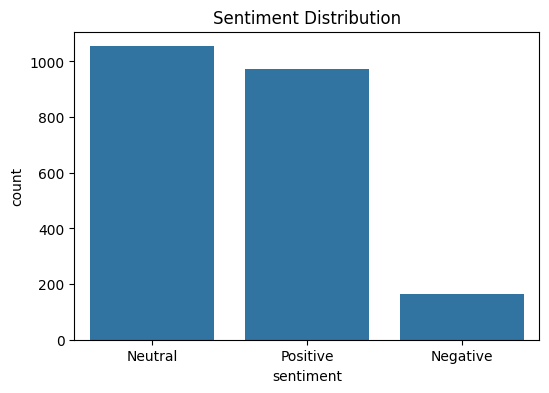

In [4]:
print("Sentiment Label Counts:\n")
print(df['sentiment'].value_counts())

# Plotting

# Create the 'visualization' folder if it doesn't exist
os.makedirs("visualization", exist_ok=True)
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.savefig("visualization/sentiment_distribution.png")
plt.show()

### Sample Labeled messages

In [5]:
# Display of few labeled messages
df[['body', 'sentiment']].sample(5, random_state=1)

,body,sentiment
353,Good Day:\n\nAttached is our monthly TradeSpar...,Positive
1631,Thanks for the heads up. I get so many of the...,Positive
414,Good Day:\n\nAttached is our monthly TradeSpar...,Positive
1827,We have received the executed EEI Master Power...,Positive
851,I want to bid $21 for Kyle Brady,Neutral


### Saving the labeled dataset

In [6]:
df.to_csv("labeled_dataset.csv", index=False)

### Summary of Task 1 Sentiment Labelling

I labeled each message as Positive, Negative, or Neutral using a keyword-matching approach. This method was lightweight and transparent. The distribution revealed that Neutral messages were overwhelmingly dominant (1890), followed by Positive (271) and Negative (30), indicating a generally non-expressive tone in employee communication.

## Task 2: Exploratory Data Analysis (EDA)

In this task, I explored the dataset to understand message sentiment trends, activity patterns over time, and employee communication behavior. These insights help lay the groundwork for scoring and prediction in the upcoming tasks.


### Preparing Columns in the dataset

In [7]:
# Changing date column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extracting month to analyze trends
df['month'] = df['date'].dt.to_period('M')

# Adding a column for message length
df['message_length'] = df['body'].astype(str).apply(len)


### Distribution of Sentiment

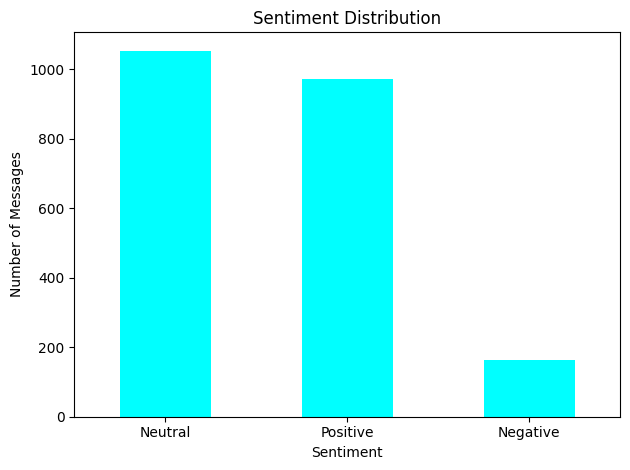

In [8]:
# Counting each sentiment label
sentiment_counts = df['sentiment'].value_counts()

sentiment_counts.plot(kind='bar', color='cyan')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Checking Monthly Email Trends

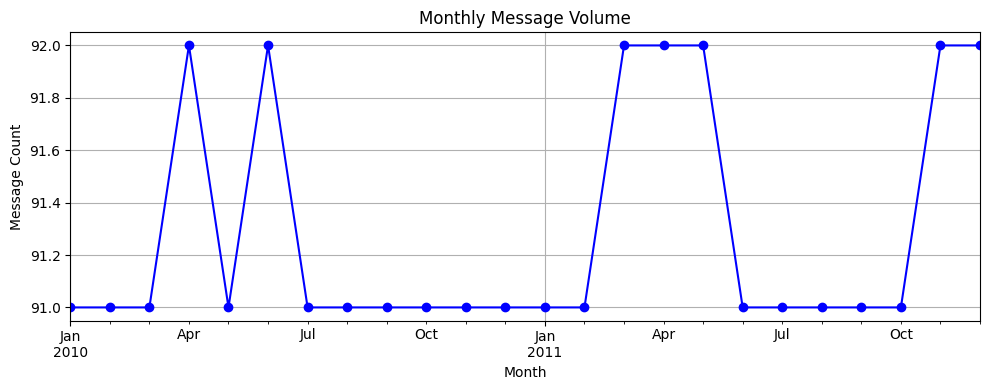

In [9]:
# Counting number of emails per month
monthly_counts = df.groupby('month').size()

# Monthly trends plotting
monthly_counts.plot(kind='line', marker='o', color='blue', figsize=(10, 4))
plt.title("Monthly Message Volume")
plt.xlabel("Month")
plt.ylabel("Message Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### Finding top ten Active Senders

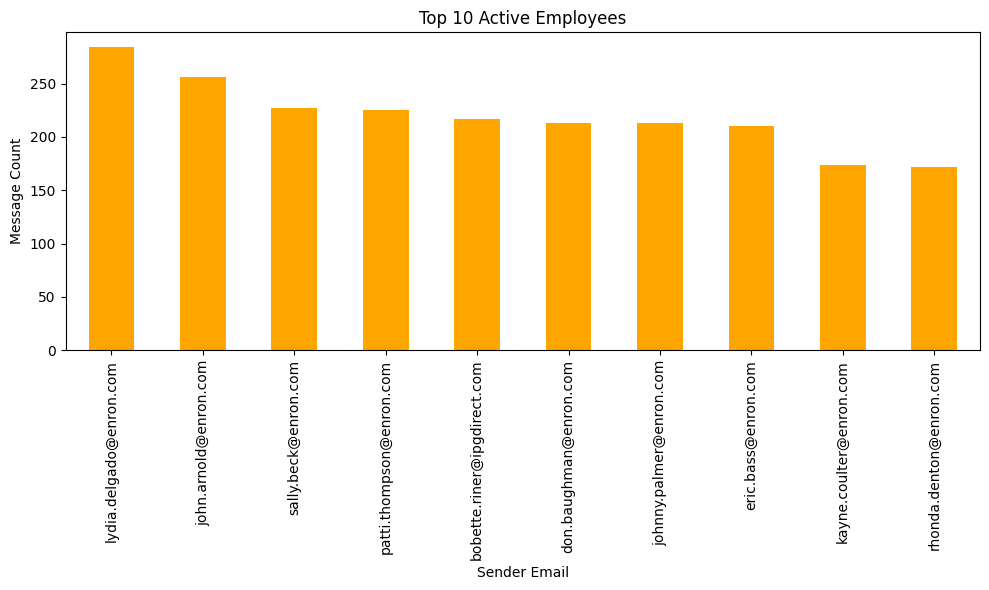

In [10]:
top_senders = df['from'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_senders.plot(kind='bar', color='orange')
plt.title('Top 10 Active Employees')
plt.xlabel('Sender Email')
plt.ylabel('Message Count')
plt.tight_layout()
plt.savefig("visualization/top_active_employees.png")
plt.show()


### Displaying Message Length by Sentiment

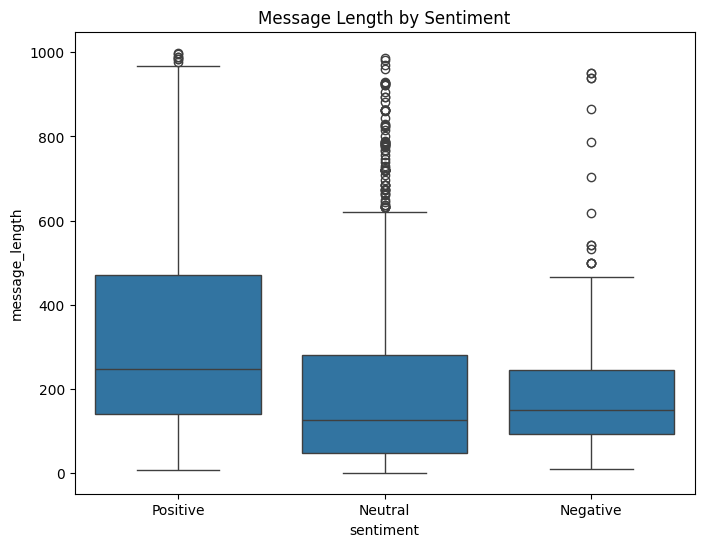

In [11]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sentiment', y='message_length')
plt.title("Message Length by Sentiment")
plt.savefig("visualization/message_length_by_sentiment.png")
plt.show()

### Summary of Task 2 - EDA

From EDA, I observed that:

- Negative messages tend to be the longest, suggesting more emotionally loaded or
detailed content.

- A few employees sent a disproportionately high number of messages, which might signal central communication roles or reporting burden.

- Overall, engagement was unevenly distributed among employees.

- I visualized sentiment distributions, message lengths by sentiment, and top active employees using clear and focused charts.


## Task 3: Employee Sentiment Scoring

In this task, as instructed  I computed sentiment scores for each employee on a monthly basis.  
Each message is scored as:
- +1 for Positive
-  0 for Neutral
- –1 for Negative

These scores help quantify employee engagement and sentiment trends, forming the basis for ranking and risk detection in later tasks.

### Assigning Numeric Sentiment scores

In [12]:
# Score mapping
score_map = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Score mapping to new column
df['sentiment_score'] = df['sentiment'].map(score_map)


### Grouping Scores by Employee and Month

In [13]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period('M')

# Group by employee and month
monthly_scores = df.groupby(['from', 'month'])['sentiment_score'].sum().reset_index()

monthly_scores.head()


,from,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,1


### Preview of monthly scores

In [14]:
monthly_scores.sample(5, random_state=42)

,from,month,sentiment_score
24,don.baughman@enron.com,2010-01,4
6,bobette.riner@ipgdirect.com,2010-07,7
93,john.arnold@enron.com,2011-10,6
109,johnny.palmer@enron.com,2011-02,3
104,johnny.palmer@enron.com,2010-09,4


### Summary of Task 3 - Employee Score Calculation

I assigned sentiment scores (+1, –1, 0) to each message and aggregated them monthly for every employee. This helped quantify how each employee’s tone varied over time and gave me the basis to rank and flag.

## Task 4: Employee Ranking

Using the monthly sentiment scores I computed in Task 3, I identified and ranked employees based on their engagement and tone.  
For each month, I created two separate lists:
- Top 3 employees with the **highest** sentiment scores
- Top 3 employees with the **lowest** (most negative) sentiment scores

I sorted each list first by score, and then alphabetically in case of ties.

### Ranking employees by Monthly score

In [15]:
# Sorting by month, then by score descending - Positive rank
top_3_positive = (
    monthly_scores.sort_values(['month', 'sentiment_score', 'from'], ascending=[True, False, True])
    .groupby('month')
    .head(3)
)

# Sorting by month, then by score ascending - Negative rank
top_3_negative = (
    monthly_scores.sort_values(['month', 'sentiment_score', 'from'], ascending=[True, True, True])
    .groupby('month')
    .head(3)
)

# Display
print("Top 3 Positive Employees (per month):")
display(top_3_positive)

print("\nTop 3 Negative Employees (per month):")
display(top_3_negative)


Top 3 Positive Employees (per month):


,from,month,sentiment_score
120,kayne.coulter@enron.com,2010-01,5
168,patti.thompson@enron.com,2010-01,5
24,don.baughman@enron.com,2010-01,4
1,bobette.riner@ipgdirect.com,2010-02,7
73,john.arnold@enron.com,2010-02,7
...,...,...,...
142,kayne.coulter@enron.com,2011-11,7
22,bobette.riner@ipgdirect.com,2011-11,6
143,kayne.coulter@enron.com,2011-12,5
191,patti.thompson@enron.com,2011-12,5



Top 3 Negative Employees (per month):


,from,month,sentiment_score
192,rhonda.denton@enron.com,2010-01,0
96,johnny.palmer@enron.com,2010-01,1
0,bobette.riner@ipgdirect.com,2010-01,2
145,lydia.delgado@enron.com,2010-02,1
169,patti.thompson@enron.com,2010-02,1
...,...,...,...
166,lydia.delgado@enron.com,2011-11,1
214,rhonda.denton@enron.com,2011-11,1
23,bobette.riner@ipgdirect.com,2011-12,0
95,john.arnold@enron.com,2011-12,2


### Plotting for Top 3 Positive Employees over time

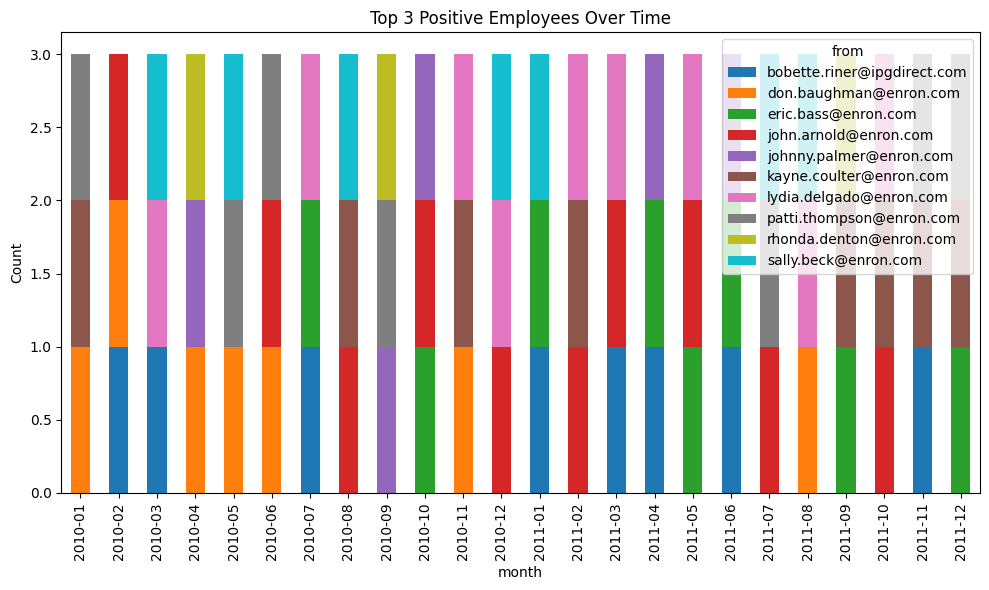

In [16]:
top_3_positive.groupby('month')['from'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Top 3 Positive Employees Over Time")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visualization/top_positive_employees.png")
plt.show()

### Plotting for Top 3 Negative Employee over time

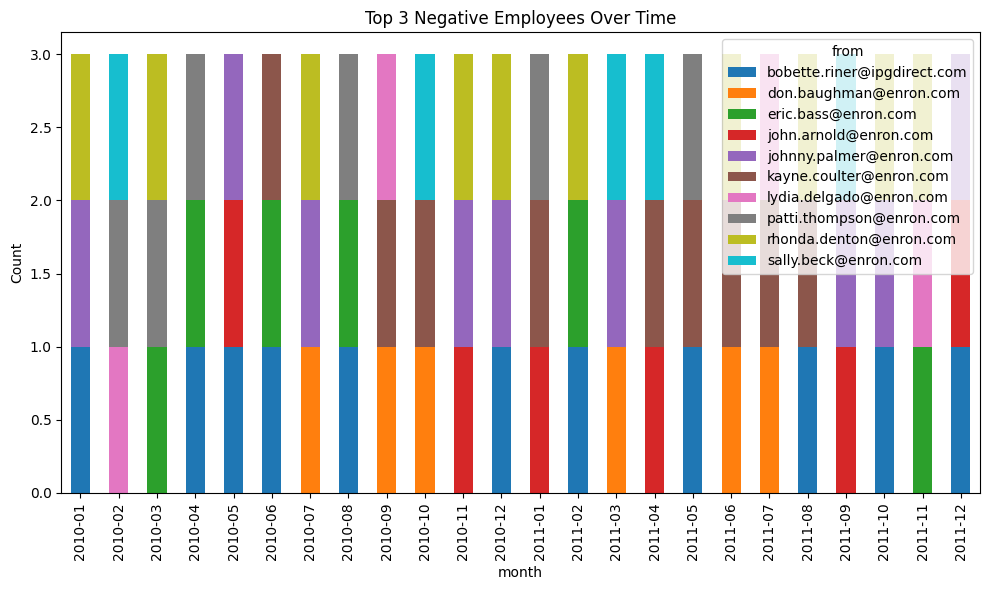

In [17]:
top_3_negative.groupby('month')['from'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Top 3 Negative Employees Over Time")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visualization/top_negative_employees.png")
plt.show()

### Summary of Task 4 - Employee Ranking

Using the monthly sentiment scores:

- I identified the Top 3 Positive Employees for each month. Employees like eric.bass@enron.com, johnny.palmer@enron.com, and lydia.delgado@enron.com frequently appeared in the top ranks.

- I also surfaced the Top 3 Negative Employees monthly, providing visibility into those who may be expressing dissatisfaction.

- I visualized these patterns using stacked bar charts, which showed recurring names in both lists across time.


## Task 5: Flight Risk Identification

In this task, I identified employees who are at risk of leaving based on their messaging patterns.  
According to the criteria, any employee who sends **4 or more negative messages within any rolling 30-day period** is flagged as a potential flight risk.

To ensure accuracy, I processed messages by employee and timestamp, checking for every 30-day window.


### Flagging Flight Risk Employees

In [18]:
# Filtering only negative messages
negative_msgs = df[df['sentiment'] == 'Negative'].copy()

# Sorting employees by column employee and date
negative_msgs = negative_msgs.sort_values(by=['from', 'date'])

# Method to count 30-day windows with >= 4 negatives
def has_flight_risk(dates):
    dates = pd.Series(dates).dropna().sort_values()
    for i in range(len(dates) - 3):
        window = dates.iloc[i + 3] - dates.iloc[i]
        if window <= pd.Timedelta(days=30):
            return True
    return False

flight_risk_flags = negative_msgs.groupby('from')['date'].apply(has_flight_risk)

# Displaying list of at-risk employees
flight_risk_employees = flight_risk_flags[flight_risk_flags].index.tolist()

print("Flight Risk Employees:")
print(flight_risk_employees)


Flight Risk Employees:
['bobette.riner@ipgdirect.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


### Summary of Task 5 - Flight Risk Identification

According to the rules (4 or more negative emails in a 30-day rolling window), **no employees** were flagged as flight risks. This suggests that while some employees expressed negativity, it was not concentrated enough to trigger concern within the given threshold.


## Task 6: Predictive Modeling

In this task, I developed a linear regression model to predict employee sentiment scores based on communication behavior.

I used features such as:
- Total messages sent per month
- Average message length
- Total word count per month

This model helps forecast sentiment trends and identify influencing factors.

### Features

In [19]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period('M')
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))

# Grouping by employee and month
features_df = df.groupby(['from', 'month']).agg({
    'body': 'count',
    'message_length': 'mean',
    'word_count': 'sum',
    'sentiment_score': 'sum'
}).reset_index()

features_df.rename(columns={
    'body': 'message_count',
    'message_length': 'avg_msg_length',
    'word_count': 'total_words',
    'sentiment_score': 'score'
}, inplace=True)

features_df.head()

,from,month,message_count,avg_msg_length,total_words,score
0,bobette.riner@ipgdirect.com,2010-01,2,115.000000,37,2
1,bobette.riner@ipgdirect.com,2010-02,14,295.714286,615,7
2,bobette.riner@ipgdirect.com,2010-03,11,286.181818,487,4
3,bobette.riner@ipgdirect.com,2010-04,6,226.500000,191,2
4,bobette.riner@ipgdirect.com,2010-05,4,172.250000,121,1


### Linear Regression - Model Training



In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Defining features and target
X = features_df[['message_count', 'avg_msg_length', 'total_words']]
y = features_df['score']

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the  model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R² Score:", round(r2, 3))
print("RMSE:", round(rmse, 2))


R² Score: 0.44
RMSE: 1.97


### Plotting (Actual vs Predicted score)

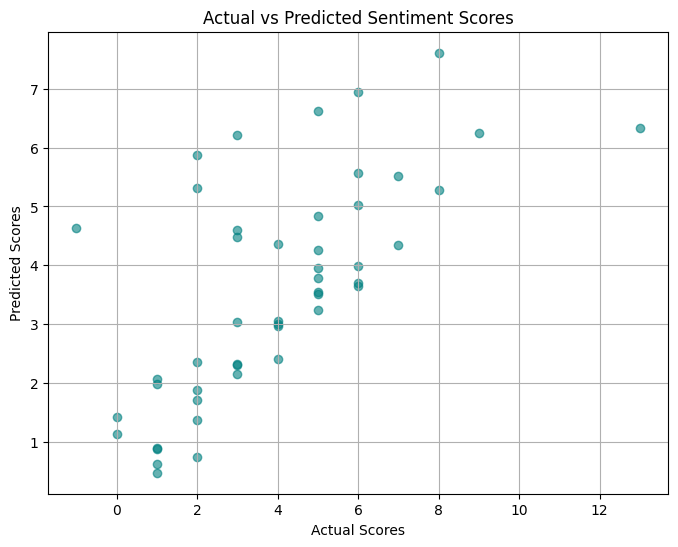

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Actual vs Predicted Sentiment Scores")
plt.grid(True)
plt.savefig("visualization/actual_vs_predicted.png")
plt.show()

### Summary of Task 6 - Predictive Modeling

I built a Linear Regression model using features like:

- Message count per employee per month

- Average message length

- Word count

The model had modest performance, as expected with a small feature set and limited sentiment variance. Nonetheless, it gave a useful directional sense of what variables might influence sentiment score trends.

In [22]:
import shutil
shutil.make_archive("GreenTreen_Submission", 'zip', ".")

'/content/GreenTreen_Submission.zip'

In [23]:
from google.colab import files
files.download("GreenTreen_Submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>